## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [107]:
import os
import time
import numpy as np
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [108]:
def load_annotations(healthy_path, jaundiced_path):
    with open(healthy_path, "r") as f:
        healthy_annotations = json.load(f)

    healthy_polygons = {}
    for image_name, data in healthy_annotations.items():
        if "regions" in data:
            healthy_polygons[image_name] = [
                np.column_stack((
                    region["shape_attributes"]["all_points_x"], 
                    region["shape_attributes"]["all_points_y"]
                ))
                for region in data["regions"].values()
            ]
        else:
            healthy_polygons[image_name] = []

    with open(jaundiced_path, "r") as f:
        jaundiced_data = json.load(f)

    image_id_to_filename = {img["id"]: img["file_name"] for img in jaundiced_data["images"]}

    jaundiced_polygons = {}
    for ann in jaundiced_data.get("annotations", []):
        image_id = ann["image_id"]
        file_name = image_id_to_filename.get(image_id)

        if "segmentation" in ann and file_name:
            if file_name not in jaundiced_polygons:
                jaundiced_polygons[file_name] = []

            for poly in ann["segmentation"]:
                points = np.array(poly, dtype=np.int32).reshape(-1, 2)
                jaundiced_polygons[file_name].append(points)

    return healthy_polygons, jaundiced_polygons



healthy_annotations_path = "./anno/annotations_healthy.json"
jaundiced_annotations_path = "./anno/annotations_Jaundice.json"

healthy_polygons, jaundiced_polygons = load_annotations(healthy_annotations_path, jaundiced_annotations_path)

# Debugging: Check a sample
print("Healthy Image Example:", list(healthy_polygons.keys())[:2])
print("Jaundiced Image Example:", list(jaundiced_polygons.keys())[:2])


Healthy Image Example: ['image_01.jpg', 'image_01_flipped.jpg']
Jaundiced Image Example: ['image_03.jpg', 'image_03_flipped.jpg']


In [109]:
def extract_kmeans_features(image, polygons, num_clusters=6):
    image = np.array(image.convert("RGB"))
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    for poly in polygons:
        if len(poly) >= 3:  # Ensure polygon has at least 3 points
            cv2.fillPoly(mask, [poly], 255)
    
    masked_hsv = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    hue_values = masked_hsv[:, :, 0][mask > 0].flatten()

    if len(hue_values) > 0:
        hue_values = hue_values.reshape(-1, 1)
        kmeans = KMeans(n_clusters=min(num_clusters, len(hue_values)), random_state=0, n_init=10)
        kmeans.fit(hue_values)
        dominant_hues = kmeans.cluster_centers_.flatten() / 180.0
        return np.pad(dominant_hues, (0, num_clusters - len(dominant_hues)), 'constant')
    else:
        return np.zeros(num_clusters)


def load_images_and_labels(folder, label, annotation_dict, num_clusters=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.load_img(image_path)

        polygons = annotation_dict.get(file, [])

        if isinstance(polygons, list):
            polygons = [np.array(p, dtype=np.int32) for p in polygons if len(p) >= 3]

        color_features = extract_kmeans_features(image, polygons, num_clusters)
        images.append(color_features.reshape(1, -1))

    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)


In [110]:
def load_images_without_annotations(folder, label, num_clusters=6):
    images = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = tf.keras.utils.load_img(image_path)

        # No polygons, just process the whole image
        color_features = extract_kmeans_features(image, [], num_clusters)
        images.append(color_features.reshape(1, -1))

    labels = [label] * len(images)
    return np.vstack(images), np.array(labels)

In [111]:
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels(
    "./train/train J", 1, jaundiced_polygons
)
train_healthy_images, train_healthy_labels = load_images_and_labels(
    "./train/train N", 0, healthy_polygons
)

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))
X_train, y_train = shuffle(X_train, y_train, random_state=1)


test_jaundiced_images, test_jaundiced_labels = load_images_without_annotations(
    "./new/Jaundiced Class/test", 1
)
test_healthy_images, test_healthy_labels = load_images_without_annotations(
    "./new/Normal Class/test", 0
)

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))


val_jaundiced_images, val_jaundiced_labels = load_images_without_annotations(
    "./new/Jaundiced Class/validate", 1
)
val_healthy_images, val_healthy_labels = load_images_without_annotations(
    "./new/Normal Class/validate", 0
)

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Jaundiced images shape:", train_jaundiced_images.shape)
print("Healthy images shape:", train_healthy_images.shape)
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("First 5 rows of X_train:", X_train[:15])

c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Test data shape: (120, 6)
Validation data shape: (245, 6)
Jaundiced images shape: (399, 6)
Healthy images shape: (497, 6)
X_train shape: (896, 6)
X_train dtype: float64
First 5 rows of X_train: [[0.10076507 0.12711044 0.0664689  0.08323413 0.11434459 0.04033816]
 [0.09329004 0.06603376 0.1103965  0.0247619  0.08139026 0.05038314]
 [0.09148886 0.06693767 0.10260197 0.03985261 0.08089242 0.11378788]
 [0.97797158 0.01141141 0.62407407 0.78730159 0.90117845 0.94558532]
 [0.59876543 0.02112112 0.94511494 0.68010446 0.07174261 0.80606996]
 [0.06604938 0.16997354 0.10061493 0.08372799 0.12909091 0.15088889]
 [0.02289973 0.97407407 0.39212377 0.09750656 0.56888889 0.82592593]
 [0.1322203  0.09751581 0.07435897 0.11779896 0.03070707 0.14880952]
 [0.82495974 0.05411765 0.61974089 0.93515755 0.69828605 0.58564426]
 [0.60149254 0.02154195 0.95281987 0.70071225 0.84326241 0.13518519]
 [0.7047619  0.89666667 0.81759259 0.95555556 0.76296296 0.65555556]
 [0.08888889 0.07548237 0.10008292 0.06360153 0

In [112]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (896, 6)
X_test shape: (120, 6)
X_val shape: (245, 6)


In [113]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit 
X_test = scaler.transform(X_test)       # Transform test data (images only with no annotations but with features)
X_val = scaler.transform(X_val)

In [114]:
model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(0.01), input_dim=X_train.shape[1]),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),  
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')  # Binary classification
])

C:\Users\kenji\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision()]
)

# Callbacks Early Stopping and Reduce LR on Plateau
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#Training
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    #callbacks=[early_stopping, lr_scheduler]
)

elapsed_time = time.time() - start_time

# Evaluate Model
loss, accuracy, precision = model.evaluate(X_test, y_test)
stopped_epoch = early_stopping.stopped_epoch

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Precision: {precision:.4f}")
print(f"Training stopped at Epoch: {early_stopping.stopped_epoch}, Time Taken: {elapsed_time:.2f} sec")


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6434 - loss: 5.4729 - precision_14: 0.5903 - val_accuracy: 0.4612 - val_loss: 5.4679 - val_precision_14: 0.4612
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8313 - loss: 5.1839 - precision_14: 0.7745 - val_accuracy: 0.4612 - val_loss: 5.4226 - val_precision_14: 0.4612
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8400 - loss: 5.1074 - precision_14: 0.7769 - val_accuracy: 0.4612 - val_loss: 5.3774 - val_precision_14: 0.4612
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8306 - loss: 5.0727 - precision_14: 0.7567 - val_accuracy: 0.4612 - val_loss: 5.3358 - val_precision_14: 0.4612
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8521 - loss: 4.9656 - precision_14: 0.7840 - val_accuracy: 0.4612 - val_loss: 5.3012 - val_precision_14: 0.4612
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8450 - loss: 4.9404 - precision_14: 0.8110 - val_accura

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70        65
           1       0.00      0.00      0.00        55

    accuracy                           0.54       120
   macro avg       0.27      0.50      0.35       120
weighted avg       0.29      0.54      0.38       120



c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kenji\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

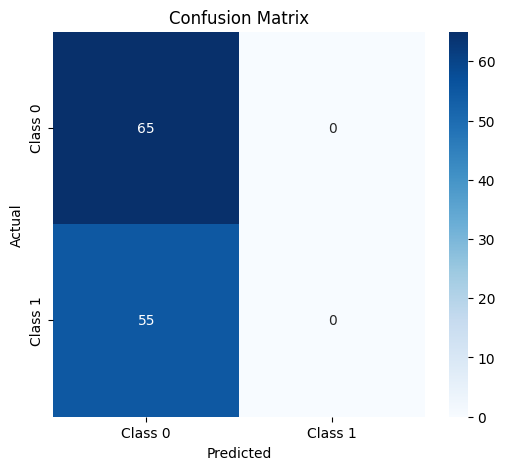

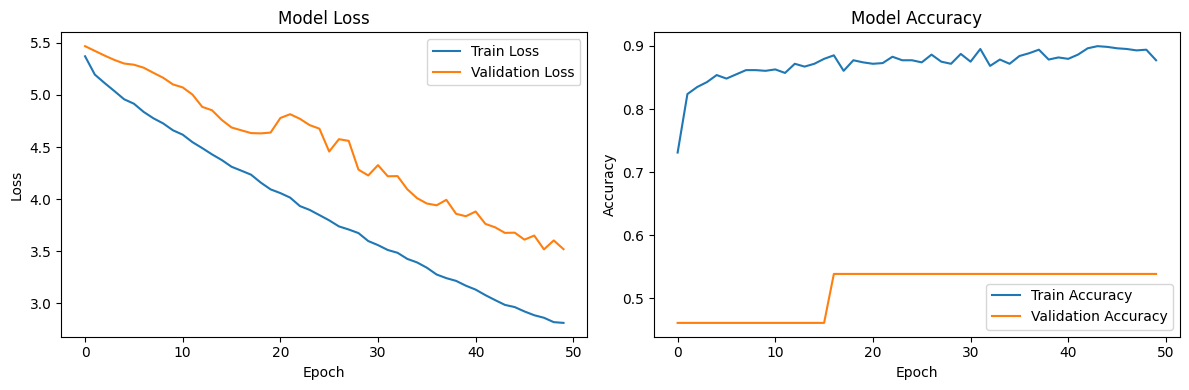

In [116]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy Plots
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [117]:
model.save("Jaundice_Classifier_kmeans1.keras") 